In [4]:
Material = "Ge"

file_path =Material+".txt"

with open(file_path, "r") as cif:
    lines = cif.readlines()
#a = lines[lines.index("_cell_length_a 6.636"+"\n")].split()[1]
matchers = ["_cell_length_a", "_cell_length_b", "_cell_length_c", "_cell_angle_alpha", "_cell_angle_beta", "_cell_angle_gamma"]
values = [line for line in lines if any(matcher in line for matcher in matchers)]#[0].split()[1]
a, b, c, alfa, beta, gamma = [float(element.split()[1]) for element in values]
#queste variabili sono già trasformate in numero

'''vectors = []
for i, line in enumerate(lines):
    if line.startswith("_space_group_symop_operation_xyz"):
        for j in range(i + 1, len(lines)):
            if lines[j].startswith("loop_"):
                break
            elif lines[j].startswith(" "):
                vectors.append(lines[j].strip())
print(vectors)
vectors = [vector.strip("'").split(",") for vector in vectors] # remove '
print(vectors)

for vector in vectors:
    for i in range(len(vector)):
        vector[i]= vector[i].replace("x", str(a))
        vector[i]= vector[i].replace("y", str(b))
        vector[i]= vector[i].replace("z", str(c))
print(vectors)'''

'vectors = []\nfor i, line in enumerate(lines):\n    if line.startswith("_space_group_symop_operation_xyz"):\n        for j in range(i + 1, len(lines)):\n            if lines[j].startswith("loop_"):\n                break\n            elif lines[j].startswith(" "):\n                vectors.append(lines[j].strip())\nprint(vectors)\nvectors = [vector.strip("\'").split(",") for vector in vectors] # remove \'\nprint(vectors)\n\nfor vector in vectors:\n    for i in range(len(vector)):\n        vector[i]= vector[i].replace("x", str(a))\n        vector[i]= vector[i].replace("y", str(b))\n        vector[i]= vector[i].replace("z", str(c))\nprint(vectors)'

# CODICE STRUTTURA

## Parte 1

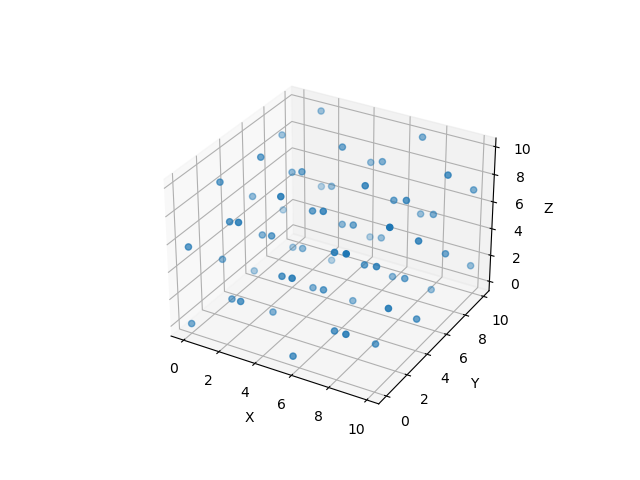

In [5]:
%matplotlib widget
import numpy as np
from pymatgen.core import Structure
from pymatgen.analysis.chemenv.utils import coordination_geometry_utils as cgu
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the crystal structure of silicon
path_cif = Material+".cif"
structure = Structure.from_file(path_cif)

# Replicate the unit cell to obtain a larger cell
supercell = structure.make_supercell([2, 2, 2])

# Extract the positions of the atoms
positions = structure.cart_coords

# Round the coordinates of each position to two decimal places
for position in positions:
    for coordinate in position:
        coordinate = round(coordinate,2)
    #print(position)
#print(positions)

# Plot the positions of the atoms in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()




In [6]:
#selection of the axis for plane/axis projection
asse = r"1 0 0"
print ("asse ", np.fromstring(asse, dtype=int, sep=" "))

## Creates the axis vector to project all the points on the plane (normalizing it)##
norm_vector = np.fromstring(asse, dtype=int, sep=" ")
norma = np.linalg.norm(norm_vector)
norm_vector = norm_vector/norma

vector_projections = []
for position in positions:
    pr_scalar = np.dot(position, norm_vector) * norm_vector
    #print(" position", position)
    #print(" pr_scalar", pr_scalar)
    #projection = pr_scalar/norma
    vector_projection = np.array(position) - (pr_scalar) # projection *
    vector_projections.append(vector_projection)

#print(vector_projections)


asse  [1 0 0]


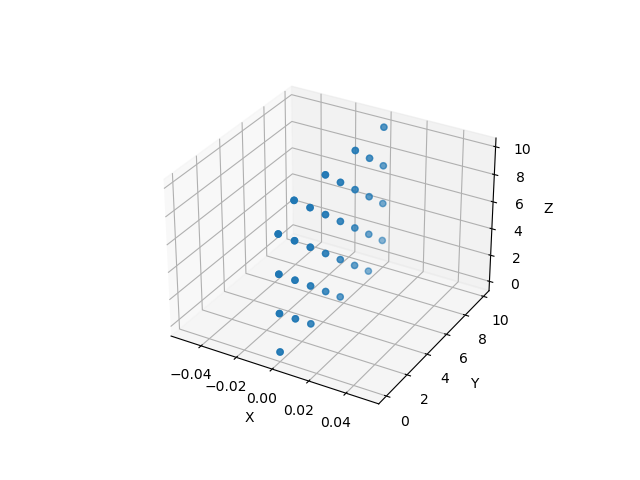

In [7]:
soglia = 1e-10

# Iterate over the vector projections and convert them all to np.arrays
for prj in vector_projections:
    # Set values smaller than the threshold to zero
    prj[np.abs(prj)< soglia] = 0.0
    #print(prj)

# Convert the vector projections to a numpy array
ndarray_projs = np.array(vector_projections)

# Plot the vector projections in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ndarray_projs[:,0], ndarray_projs[:,1], ndarray_projs[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


[ 0. -1.  0.]
90.0


Text(0.5, 0, 'Z')

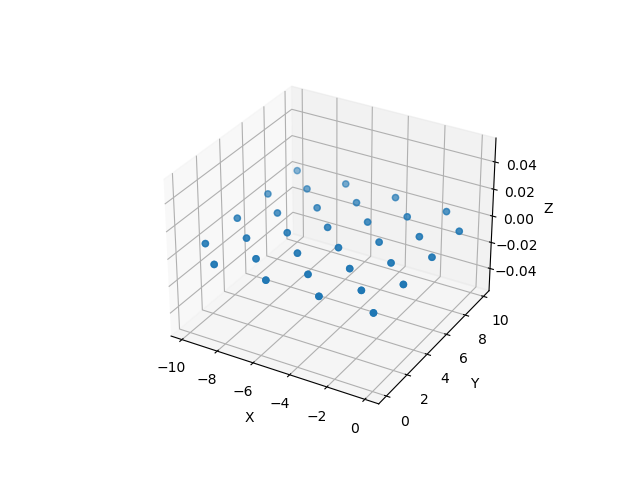

In [8]:
# Define three base vectors for x, y and z
x_base = np.array([1, 0, 0])
y_base = np.array([0, 1, 0])
z_base = np.array([0, 0, 1])

# Calculate the rotation axis for a given normal vector
rotation_axis = np.cross(norm_vector, z_base)
print(rotation_axis)

# Calculate the rotation angle for a given normal vector
angle = np.arccos(np.dot(norm_vector,z_base)/(np.sqrt(norm_vector[0]**2 + norm_vector[1]**2 + norm_vector[2]**2)*np.sqrt(z_base[0]**2 + z_base[1]**2 + z_base[2]**2)))
print(np.degrees(angle))

# Define the rotation matrix for a given rotation axis and angle
c = np.cos(angle)
def rotation_matrix(axis, theta):
    """
    Returns the rotation matrix for a rotation around a specified axis by a specified angle in radians 
    using Rodrigues' formula.
    """
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta/2.)
    b, c, d = -axis * np.sin(theta/2)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

# Calculate the rotated projection vectors
R = rotation_matrix(rotation_axis, angle)
r_ndarray_projs = []
for p in ndarray_projs:
    r_ndarray_proj = np.dot(R, p)
    #print("rotated",r_ndarray_proj)
    r_ndarray_projs.append(r_ndarray_proj)

# Apply a threshold to each of the rotated projection vectors
for prj in r_ndarray_projs:
    prj[np.abs(prj) < soglia] = 0.0

# Plot the rotated projection vectors in 3D space
r_ndarray_projs = np.array(r_ndarray_projs)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r_ndarray_projs[:,0], r_ndarray_projs[:,1], r_ndarray_projs[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


In [9]:
x_positions = []
y_positions = []
atom_positions = []
for a in range(0,len(r_ndarray_projs)):
    atom_positions.append((round(r_ndarray_projs[a][0],3),round(r_ndarray_projs[a][1],3)))
    x_positions.append(round(r_ndarray_projs[a][0],3))
    y_positions.append(round(r_ndarray_projs[a][1],3))
#print(atom_positions)
atom_positions = list(set(atom_positions))
#print("at_pos", atom_positions)
print(len(atom_positions))


32


In [10]:
posizioni_proiettate = []

for position in positions:
    p_scalare = np.dot(position, norm_vector)

    # calculates the length of the projection vector
    norma_asse = np.linalg.norm(norm_vector)

    # calcola la proiezione della posizione lungo l'asse
    d_proiezione = round(p_scalare / norma_asse, 3)

    posizioni_proiettate.append(d_proiezione)

posizioni_proiettate = list(set(posizioni_proiettate))
#print(posizioni_proiettate)

planar_distances = [round(posizioni_proiettate[n+1]-posizioni_proiettate[n],2) for n in range(0, len(posizioni_proiettate)-1)]
d_pl = []
if planar_distances.count(planar_distances[0]) == len(planar_distances):
    d_pl.append(planar_distances[0])
else:
    d_pl = list(set(planar_distances))
print("d_pl = ",d_pl)

################################## d_at CALCULATION ##################################

def punto_retta_scalare(v1,r):
    r_norm = np.linalg.norm(r)
    v1_norm = np.linalg.norm(v1)
    # print (round(v1_norm,2))
    # print (round(r_norm,2))
    pr_scalar=np.dot(v1, r)
    # print (pr_scalar, " -- ", v1_norm*r_norm)
    if abs(pr_scalar - v1_norm*r_norm)<0.01:
        return True
    else:
        return False
    
pos_ax =[]
for position in positions:
    test2 = punto_retta_scalare(position,norm_vector*norma)
    if test2 == True:
        #print (position)
        pos_ax.append(position) 


for at in pos_ax: #to make all np.arrays
    # print (atoms)
    at[np.abs(at)< soglia] = 0.0
    

pos_ax=np.sort(np.array(pos_ax), axis=0)
axial_projections = [np.sqrt((at[0])**2+(at[1])**2+(at[2])**2) for at in pos_ax] # è un nome a caso

axial_distances = [round(axial_projections[n+1]-axial_projections[n],2) for n in range(0, len(axial_projections)-1)]
d_at = []
if axial_distances.count(axial_distances[0]) == len(axial_distances):
    d_at.append(axial_distances[0])
else:
    d_at = list(set(axial_distances))
print("d_at = ",d_at)

'''fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_ax[:,0], pos_ax[:,1], pos_ax[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()'''

d_pl =  [1.41, 1.42]
d_at =  [5.66]


"fig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nax.scatter(pos_ax[:,0], pos_ax[:,1], pos_ax[:,2])\nax.set_xlabel('X')\nax.set_ylabel('Y')\nax.set_zlabel('Z')\nplt.show()"

In [16]:
#################################################################### Silicon
if "Si" in path_cif:
    coeff_a = [1.876, 2.617, 0.8604, 0.3903, 0.07769]
    coeff_b = [62.11, 18.68, 3.935, 0.7690, 0.0823]
    coeff_a_err = 0.5067 * 10**(-3)
    coeff_B = [b/(4*(np.pi)**(2)) for b in coeff_b]
    u = 0.075 #preso da sytov thesis
    N = 4.995E-2 #atomic concentration
    Z = 14
################################################################### Germanium
elif "Ge" in path_cif:
    coeff_a = [0.2259E+01, 0.2746E+01, 0.1533E+01, 0.6738E+00, 0.1563E+00]
    coeff_b = [0.5883E+02, 0.1588E+02, 0.2957E+01, 0.6679E+00, 0.7455E-01]
    coeff_a_err = 0.1432E-02
    coeff_B = [b/(4*(np.pi)**(2)) for b in coeff_b]
    u = 0.085 #from Baier Katkov
    N = 4.4E-2 #atomic concentration
    Z = 32
############################## COEFF MOLIERE
alfa = [0.1, 0.55, 0.35]
beta = [6.0, 1.2, 0.3]

z = 1
a_0 = 0.53 #Angstrom
e = 1.6E-19
a_TF = (9*np.pi**2/(128*Z))**(1/3)*a_0

def U_DT_2D(x, y, x_0, y_0):
    d_atm = sum(d_at)/len(d_at) #mean of the atomic distances
    U1 = 2/d_atm*Z*z*e*a_0
    k1 = [(coeff_a[i]/(coeff_B[i]+2*u**2))*np.exp(-((x-x_0)**2+(y-y_0)**2)/(coeff_B[i]+2*u**2)) for i in range(0,len(coeff_a))]
    k = sum(k1)
    return U1*k

################ Make the Potential calculation
x = np.linspace(min(x_positions), max(x_positions), 500)
y = np.linspace(min(y_positions), max(y_positions), 500)
xx, yy = np.meshgrid(x, y)

x_0 = [0] * 100
y_0 = [0] * 100
xx_0, yy_0 = np.meshgrid(x_0,y_0)

U_2D= np.zeros_like(xx)
for atom in atom_positions:
    U_2D += U_DT_2D(xx,yy,atom[0],atom[1])/e
    #print(x_positions[i],y_positions[i])
    #print(U_2D)
#print(len(U_2D))
#U_2D_s = np.sum(U_2D, axis=0)
U_max, U_min = [], []
for U in U_2D:
    U_max.append(max(U))
    U_min.append(min(U))
    
U_top, U_bottom = max(U_max), min(U_min)
print(U_top, U_bottom)

U_2D -= U_bottom


339.9070833832389 5.432833736775906


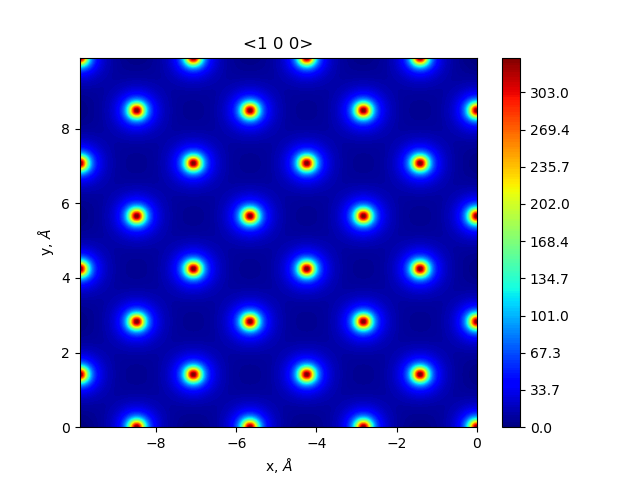

In [17]:
U_max, U_min = [], []
for U in U_2D:
    U_max.append(max(U))
    U_min.append(min(U))
    
U_top, U_bottom = max(U_max), min(U_min)

# Make the graph
levels = np.linspace(U_bottom, U_top, 150)
fig, ax=plt.subplots()
plt.contourf(xx, yy, U_2D, levels, cmap='jet') #levels,
plt.colorbar()
plt.title("<"+ asse +">") 
plt.xlabel('x, $\AA$')
plt.ylabel('y, $\AA$')
plt.show()

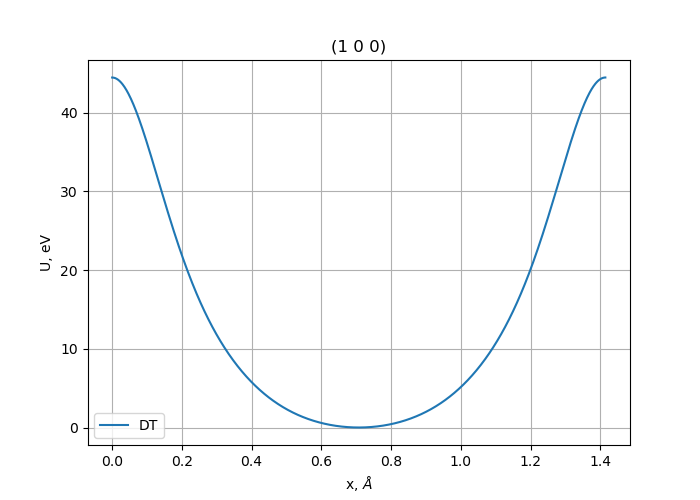

In [13]:
def U_pl_DT(x): 
    d_plm = sum(d_pl)/len(d_pl)
    U = 2*np.sqrt(np.pi)*N*d_plm*Z*z*e*a_0
    k1 = [(coeff_a[i]/np.sqrt(coeff_B[i]+2*u**2))*np.exp(-x**2/(coeff_B[i]+2*u**2)) for i in range(0,len(coeff_a))]
    k = sum(k1)
    return U*k



x_DT = np.linspace(posizioni_proiettate[posizioni_proiettate.index(0.0)], posizioni_proiettate[posizioni_proiettate.index(0.0)+len(d_at)] ,1000)
posizioni_proiettate=[p-posizioni_proiettate[int(len(posizioni_proiettate)/2)] for p in posizioni_proiettate]
#print(posizioni_proiettate)
#U_harm = U_h_100(x_DT-d_pl/2)
'''#Moliere
U_Mol = [U_M(x_DT+n*d_pl) for n in range(-nel,nel)]
U_sum_Mol = sum(U_Mol)/e
U_sum_Mol = U_sum_Mol - min(U_sum_Mol)'''
#calculate for a number of planes
U_DT=[]
for n in range(0, len(posizioni_proiettate)):
    U_DT.append(U_pl_DT(x_DT-posizioni_proiettate[n]))
U_sum_DT = sum(U_DT)/e
#subtraction of the minimum energy
U_sum_DT = [U_sum_DT1 - min(U_sum_DT) for U_sum_DT1 in U_sum_DT]

figure, ax = plt.subplots(figsize=(7,5))

ax.plot(x_DT, U_sum_DT, label="DT")
ax.set_title("("+asse+")")
ax.set_ylabel("U, eV")
ax.set_xlabel("x, $\AA$")
ax.legend()
ax.grid()
plt.show()

In [14]:
print(max(U_sum_DT),min(U_sum_DT[0:100]))

44.48656057357074 30.244539104465847
